In [0]:
import numpy as np 
import pandas as pd 
import os
import glob
import time
import cv2
import random
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.utils import class_weight
from keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from imgaug import augmenters as iaa
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

np.random.seed(1)

In [2]:
!ls

sample_data


In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [0]:
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d hasibzunair/malaria

100% 811M/815M [00:10<00:00, 92.5MB/s]
100% 815M/815M [00:10<00:00, 80.5MB/s]


In [7]:
!unzip 'malaria.zip'

Archive:  malaria.zip
  inflating: y_test.npy              
  inflating: x_test.npy              
  inflating: y_train.npy             
  inflating: y_val.npy               
  inflating: x_train.npy             
  inflating: x_val.npy               


In [8]:
!ls

kaggle.json  sample_data  x_train.npy  y_test.npy   y_val.npy
malaria.zip  x_test.npy   x_val.npy    y_train.npy


In [0]:
#x_train = np.load("x_train.npy")
#y_train = np.load("y_train.npy")
#x_train.shape, y_train.shape
#x_val = np.load("x_val.npy")
#y_val = np.load("y_val.npy")
#x_val.shape, y_val.shape
#x_test = np.load("x_test.npy")
#y_test = np.load("y_test.npy")
#x_test.shape, y_test.shape
#print(x_train.shape, y_train.shape)
#print(x_val.shape, x_test.shape, y_val.shape, y_test.shape)

In [0]:
nb_train_samples = 22046 #  modify for your dataset
nb_valid_samples = 2756 #  modify for your dataset
nb_test_samples = 2756 # modify for your dataset
num_classes = 2 # binary classification 

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
def load_resized_training_data(img_rows, img_cols):

    X_train = np.load("x_train.npy")
    Y_train = np.load("y_train.npy")
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:nb_train_samples,:,:,:]])
    
    return X_train, Y_train
    
def load_resized_validation_data(img_rows, img_cols):

    X_valid = np.load("x_val.npy")
    Y_valid = np.load("y_val.npy")
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:nb_valid_samples,:,:,:]])
        
    return X_valid, Y_valid   

def load_resized_test_data(img_rows, img_cols):

    X_test = np.load("x_test.npy")
    Y_test = np.load("y_test.npy")
    X_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_test[:nb_test_samples,:,:,:]])
    
    return X_test, Y_test

In [0]:
img_rows=224 #dimensions of image required for VGG16
img_cols=224
channel = 3 #RGB
batch_size = 32 # modify based on the GPUs in your system
num_epoch = 100 # modify depending on the model's convergence with your data

#load data
X_train, Y_train = load_resized_training_data(img_rows, img_cols)

In [0]:
X_valid, Y_valid = load_resized_validation_data(img_rows, img_cols)

In [0]:
X_test, Y_test = load_resized_test_data(img_rows, img_cols)

In [18]:
#print the shape of the data
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(22046, 224, 224, 3) (22046, 2)
(2756, 224, 224, 3) (2756, 2)
(2756, 224, 224, 3) (2756, 2)


In [14]:
IMAGE_SIZE = x_train.shape[1]
IMAGE_SIZE

200

In [20]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, channel))

#extract feature from the optimal layer for your data
base_model = Model(input=base_model.input, output=base_model.get_layer('block5_conv2').output) 

#get the model summary
base_model.summary()

58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`
  after removing the cwd from sys.path.


Lets modify the architecture by adding a global spatial average pooling layer and a fully-connected layer with a dropout ratio of 0.5 to prevent overfitting and help model generalization. We will train only the top layers which are randomly initialized, freeze all the convolutional layers to prevent large gradient updates wrecking the learned weights.

In [30]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers to prevent large gradient updates wrecking the learned weights
for layer in base_model.layers:
    layer.trainable = False

#fix the optimizer
sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True) 

#compile the model
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("The final model...")
model.summary()

The final model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0 

In [31]:
model.name

'model_4'

In [27]:
# check input
print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape)

(22046, 224, 224, 3) (22046, 2) (2756, 224, 224, 3) (2756, 2) (2756, 224, 224, 3) (2756, 2)


In [0]:
mkdir weights

In [34]:
!ls

kaggle.json  sample_data  x_test.npy   x_val.npy   y_train.npy
malaria.zip  weights	  x_train.npy  y_test.npy  y_val.npy


In [0]:
!rm -f "vgg_1a.h5"

In [38]:
#model=vgg16()
#path_model='vgg_1a.h5'  

filepath = 'weights/' + model.name + '.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_weights_only=True, save_best_only=True, mode='max', period=1)

#tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)
callbacks_list = [checkpoint]

#compute training time
t=time.time()
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 callbacks=callbacks_list,
                 epochs=num_epoch, verbose=1, 
                 shuffle=True, validation_data=[X_valid, Y_valid])

#compute the training time
print('Training time: %s' % (time.time()-t))


Train on 22046 samples, validate on 2756 samples
Epoch 1/100
22046/22046 [==============================] - 238s 11ms/step - loss: 1.4578 - acc: 0.7672 - val_loss: 0.2578 - val_acc: 0.9401

Epoch 00001: val_acc improved from -inf to 0.94013, saving model to weights/model_4.01-0.9401.hdf5
Epoch 2/100
22046/22046 [==============================] - 229s 10ms/step - loss: 0.4897 - acc: 0.8806 - val_loss: 0.2063 - val_acc: 0.9470

Epoch 00002: val_acc improved from 0.94013 to 0.94702, saving model to weights/model_4.02-0.9470.hdf5
Epoch 3/100
22046/22046 [==============================] - 229s 10ms/step - loss: 0.3333 - acc: 0.9042 - val_loss: 0.1792 - val_acc: 0.9492

Epoch 00003: val_acc improved from 0.94702 to 0.94920, saving model to weights/model_4.03-0.9492.hdf5
Epoch 4/100
22046/22046 [==============================] - 229s 10ms/step - loss: 0.2709 - acc: 0.9164 - val_loss: 0.1686 - val_acc: 0.9481

Epoch 00004: val_acc did not improve from 0.94920
Epoch 5/100
22046/22046 [=========

In [0]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(20,10), dpi=100)
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(20,10), dpi=100)
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

In [0]:
#model.load_weights('weights/model_2.01-0.8546.hdf5') #modify for your own model

In [39]:
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)

# compute the accuracy
Test_accuracy = accuracy_score(Y_test.argmax(axis=-1),y_pred.argmax(axis=-1))
print("Test_Accuracy = ",Test_accuracy)

2756/2756 [==============================] - 25s 9ms/step
Test_Accuracy =  0.9506531204644412


In [40]:
Test_accuracy

0.9506531204644412

In [48]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#Plot ROC curves
plt.figure(figsize=(12,12), dpi=100)
lw = 1
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

# computhe the cross-entropy loss score
score = log_loss(Y_test,y_pred)
print(score)

# compute the average precision score
prec_score = average_precision_score(Y_test,y_pred)  
print(prec_score)

# transfer it back
y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)
print(y_pred)
print(Y_test)

#save the predictions as a CSV file for further analysis
#np.savetxt('custom_model_y_pred.csv',y_pred,fmt='%i',delimiter = ",")
#np.savetxt('custom_model_Y_test.csv',Y_test,fmt='%i',delimiter = ",")

IndexError: ignored

In [43]:
!ls

custom_model_y_pred.csv  malaria.zip  x_test.npy   y_test.npy
custom_model_Y_test.csv  sample_data  x_train.npy  y_train.npy
kaggle.json		 weights      x_val.npy    y_val.npy


                   precision    recall  f1-score   support

class 0(abnormal)       0.95      0.95      0.95      1409
  class 1(normal)       0.95      0.95      0.95      1347

        micro avg       0.95      0.95      0.95      2756
        macro avg       0.95      0.95      0.95      2756
     weighted avg       0.95      0.95      0.95      2756

[[1343   66]
 [  70 1277]]
Confusion matrix, without normalization
[[1343   66]
 [  70 1277]]


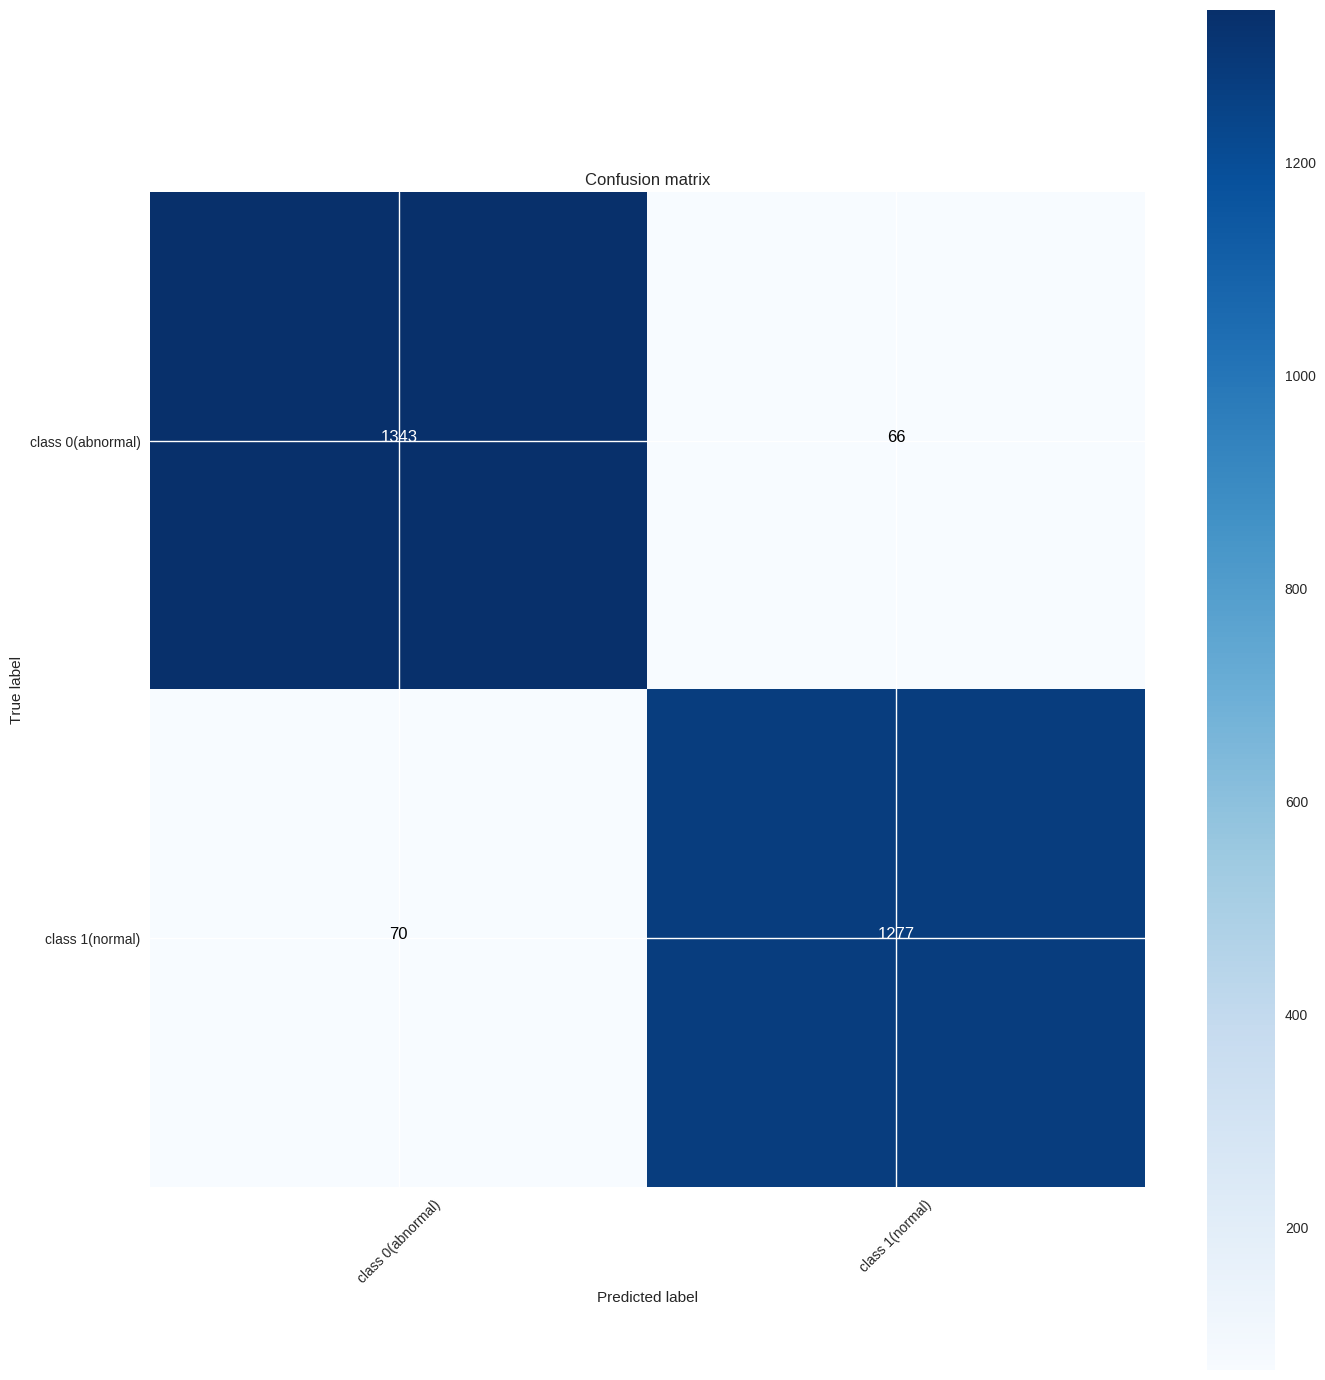

In [46]:
target_names = ['class 0(abnormal)', 'class 1(normal)'] #decide the labels for your own data
print(classification_report(Y_test,y_pred,target_names=target_names))
print(confusion_matrix(Y_test,y_pred))
cnf_matrix = (confusion_matrix(Y_test,y_pred))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(14,14), dpi=100)
plot_confusion_matrix(cnf_matrix, classes=target_names,
                  title='Confusion matrix')
plt.show()

In [0]:
!mkdir files

mkdir: cannot create directory ‘files’: File exists


In [0]:
!ls

files	     malaria.zip  vgg_1a.h5   x_train.npy  y_test.npy	y_val.npy
kaggle.json  sample_data  x_test.npy  x_val.npy    y_train.npy


In [0]:
#pred_labels.shape

(2756,)

In [0]:
#!cp pred_labels.npy files
#!cp vgg_1a.h5 files


cp: cannot stat 'pred_labels.npy': No such file or directory
cp: cannot stat 'vgg_1a.h5': No such file or directory


In [0]:
# zip folder
#!zip -r files.zip files

  adding: files/ (stored 0%)
  adding: files/pred_labels.npy (deflated 96%)
  adding: files/vgg_1a.h5 (deflated 7%)


In [0]:
!ls

files	   kaggle.json	sample_data  x_train.npy  y_test.npy   y_val.npy
files.zip  malaria.zip	x_test.npy   x_val.npy	  y_train.npy


In [0]:
from google.colab import files
files.download('files.zip') 